## Task 04: Resampling and Hyperparameter Search (2022-04-05)


So far we have used softmax, SVC, and kNN models. Now we will create them again with the same 3-storey structure dataset but using hyperparameter tuning by randomized search. To that end, provide the following items:
1. Split your dataset into a) training/validation and b) test datasets (e.g. 60/40% ratio split)

2. Use randomized search with repeated cross-validation for hyperparameter tuning. Use e.g. 
    
    A. n_splits = 5, n_repeats = 50 [RepeatedKFold]

    B. n_iter = 100, n_jobs = -1 (will use all your cores), cv = (object you created with RepeatedKFold in 2.A), scoring = (choose a performance metric for classification problems), [RandomizedSearchCV]
    
    C. Suggestion: create estimator in a list and a list of dictionaries for param_distributions, as shown in the slides [RandomizedSearchCV]

3. Try to compare with the results obtained with the default configurations of each model constructor

In [1]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [2]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# task 03
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

#allow to print all variables in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from scipy import stats


### Opening data file and Separating parameters and labels

In [3]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)


### Building AR Model

In [4]:
modelOrder = 30

x2 = dataset[:,1,:].transpose() # acelerômetro: base
x3 = dataset[:,2,:].transpose() # acelerômetro: 1o andar
x4 = dataset[:,3,:].transpose() # acelerômetro: 2o andar
x5 = dataset[:,4,:].transpose() # acelerômetro: 3o andar

x2r = [] 
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

### PCA analysis

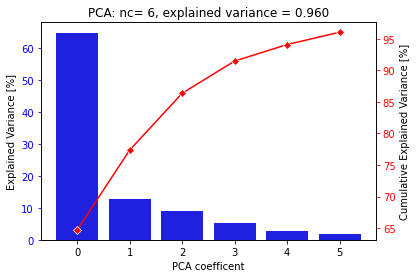

In [5]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b');
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D');
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')
pass;

### Building x2 by transforming the x1 data with the previous PCA model and scaling X2

In [6]:
X2 = pca.fit_transform(X1)
X1_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

### Creating pandas dataframe versions of the scaled x and x2, adding their labels

In [7]:
dfx1 = pd.DataFrame(X1_scaled)
dfx1 = dfx1.copy()
dfx1['label'] = y

dfx2 = pd.DataFrame(X2_scaled)
dfx2 = dfx2.copy()
dfx2['label'] = y

###  1. Split your dataset into a) training/validation and b) test datasets (e.g. 60/40% ratio split)

In [8]:
# From now on we dont use the '_scaled' for the test and train ensemples anymore
test_size = 0.40

X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=test_size, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=test_size, random_state=10)

### Softmax Linear Model (logistic regression with multiple classes) for the PCA reduced database

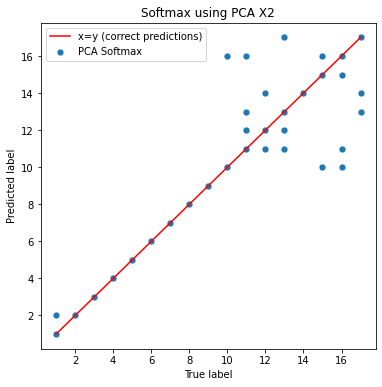

In [165]:
#PCA SOFTMAX
model_PCA_Soft = LogisticRegression(multi_class='multinomial', max_iter=200).fit(X2_train, y_train)

yPred2_train = model_PCA_Soft.predict(X2_train)
yPred2_test = model_PCA_Soft.predict(X2_test)

fig = plt.figure(figsize=(6, 6));
x=np.arange(1,18,1);

ax = sns.scatterplot(y_test,yPred2_test, s=50);
ax.set_xlabel('True label');
ax.set_ylabel('Predicted label');
ax=sns.lineplot(x=x, y=x, color='r');
ax.legend(['x=y (correct predictions)','PCA Softmax']);

ax.set_title('Softmax using PCA X2');

___

### Fitting SVM and k-NN with their default params, then saving it to a results Dataframe

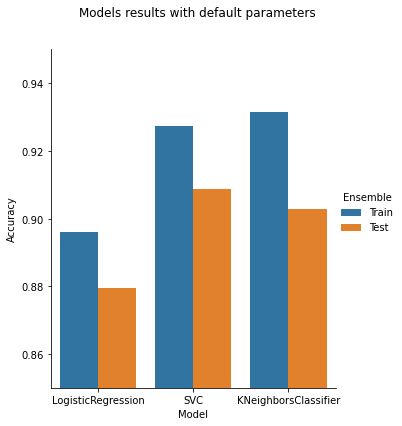

In [152]:
# Previous Model Softmax PCA
dfResults = pd.DataFrame({
        'Model': ['LogisticRegression'], 
        'Hyperparam': ['Default'], 
        'Train': accuracy_score(y_train, yPred2_train), 
        'Test': accuracy_score(y_test, yPred2_test)
        })

for i,model in enumerate([SVC(),KNeighborsClassifier()]):
    modelTrained = model.fit(X2_train, y_train)
    
    yPred_train = modelTrained.predict(X2_train)
    yPred_test = modelTrained.predict(X2_test)

    dfResults = dfResults.append(pd.DataFrame({
        'Model': [str(model).split('(')[0]],
        'Hyperparam': ['Default'], 
        'Train': accuracy_score(y_train, yPred_train), 
        'Test': accuracy_score(y_test, yPred_test)
        }))

# unpivot dfResults in case of plotting graphs
dfResultsPlot = dfResults.melt(id_vars=['Model', 'Hyperparam'], value_name='Accuracy', var_name='Ensemble')

ax = sns.catplot(x='Model', y='Accuracy', hue='Ensemble', data=dfResultsPlot, kind="bar", height=6, aspect=0.8);
ax.set(ylim=(0.85, .95));
ax.fig.subplots_adjust(top=.88) # adjust the Figure in rpxax
ax.fig.suptitle('Models results with default parameters');
# plt.xticks(rotation=0)
pass;

### 2. Use randomized search with repeated cross-validation for hyperparameter tuning. Use e.g. 

    A. n_splits = 5, n_repeats = 50 [RepeatedKFold]


In [59]:
k_folds = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=10)

rkf

RepeatedKFold(n_repeats=50, n_splits=5, random_state=10)


    B. n_iter = 100, n_jobs = -1 (will use all your cores), cv = (object you created with RepeatedKFold in 2.A), scoring = (choose a performance metric for classification problems), [RandomizedSearchCV]

    C. Suggestion: create estimator in a list and a list of dictionaries for param_distributions, as shown in the slides [RandomizedSearchCV]


In [114]:
n_iter = 100
n_jobs = -1
scoring = 'accuracy'

param_grids = []
param_grids.append([# SoftMax = 0
        {
            'penalty':  ['l2', 'none'],
            'C':    stats.randint(1,25), # def=1
            'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
        }])
param_grids.append([# SVC = 1
        {
            'C':  stats.randint(1,25), # def=1
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # excluded 'precomputed' cause it demands a square X matrix, not the case
            'degree': stats.randint(1,15), # def = 3
            'gamma': ['scale','auto']
        }])
param_grids.append([# KNN = 2
        {
            'n_neighbors':  stats.randint(3,11), # def = 5
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
            'leaf_size': stats.randint(1,50) #def = 30            
        }])

models = [LogisticRegression(multi_class='multinomial'), SVC(), KNeighborsClassifier()]

### Performing a randomized search for hyperparameters

In [119]:
rscv_results = []
for k in range(len(models)):
    random_search = RandomizedSearchCV(models[k], verbose=0, scoring=scoring, param_distributions=param_grids[k], n_iter=n_iter, n_jobs=n_jobs, cv=rkf, random_state=10);
    random_search.fit(X2_train, y_train)

    # saving rscv instance...
    rscv_results.append(random_search)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=LogisticRegression(multi_class='multinomial'),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194EAE08430>,
                                         'penalty': ['l2', 'none'],
                                         'solver': ['newton-cg', 'sag', 'saga',
                                                    'lbfgs']}],
                   random_state=10, scoring='accuracy')

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194D9D95820>,
                                         'degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194F102B4F0>,
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']}],
                   random_state=10, scoring='accuracy')

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=KNeighborsClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'algorithm': ['auto', 'ball_tree',
                                                       'kd_tree', 'brute'],
                                         'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194F102B070>,
                                         'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194D338E3A0>}],
                   random_state=10, scoring='accuracy')

In [154]:
for rscv in rscv_results:
    rscv.best_estimator_
    # rscv.best_params_
    
    y_hat = rscv.predict(X2_test)
           
    dfResults = dfResults.append(pd.DataFrame({
        'Model': [str(rscv.best_estimator_).split('(')[0]],
        'Hyperparam': 'RandomSearch', 
        'Train': rscv.best_score_, 
        'Test': accuracy_score(y_hat, y_test)
        }))


LogisticRegression(C=5, multi_class='multinomial', penalty='none')

SVC(C=11, degree=2, kernel='poly')

KNeighborsClassifier(leaf_size=43, n_neighbors=3)

In [155]:
dfResults

,Model,Hyperparam,Train,Test
0,LogisticRegression,Default,0.896078,0.879412
0,SVC,Default,0.927451,0.908824
0,KNeighborsClassifier,Default,0.931373,0.902941
0,LogisticRegression,RandomSearch,0.932392,0.920588
0,SVC,RandomSearch,0.925255,0.932353
0,KNeighborsClassifier,RandomSearch,0.896078,0.905882


### Note
For the train score we considered the property "best_score_" of the objects of the class RandomSearchCV that is a score average in the k-fold validation process

As in the default parameters set we have trained the models directly using the X2 train_test_split returned matrix, we think that this Train score is no longer a good comparison. So we will use only the Test score to compare them

### Results and Discussion

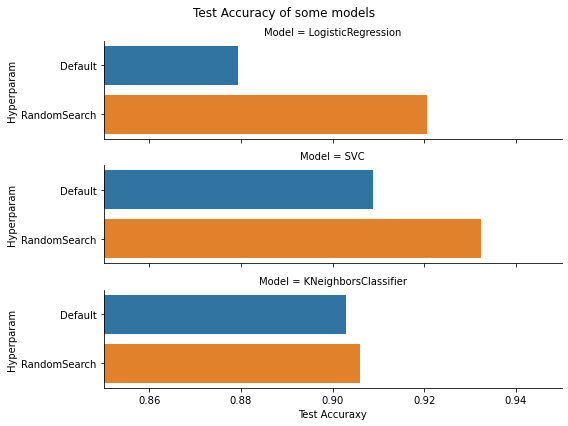

In [148]:
ax = sns.catplot(x="Test", row="Model", y="Hyperparam", data=dfResults, kind='bar', height=2, aspect=4, legend_out=True, margin_titles=False);
ax.set_xlabels("Test Accuraxy")
ax.fig.suptitle("Test Accuracy of some models")
ax.fig.subplots_adjust(top=0.9)
ax.set(xlim=(0.85, .95));
pass;

### Notes:

1. We see some improve in the quality of both three models when tunning their parameters with the random search. More discrete gain in the k-nn model was observed. Maybe due to the choice of parameters.

2. Gains of accuracy:

    * Logistic Regression (Softmax): $ \frac{accuracy(random search)}{accuracy(default)}-1 = \frac{0.9205}{0.8794}-1 = 4.7 \% $

    * SVM gain of accuracy: $ \frac{accuracy(random search)}{accuracy(default)}-1 = \frac{0.9323}{0.9088}-1 = 2.6 \% $
    
    * k-NN gain of accuracy: $ \frac{accuracy(random search)}{accuracy(default)}-1 = \frac{0.9059}{0.9029}-1 = 0.3 \% $
